In [88]:
import torch 
import numpy as np
import matplotlib.pyplot as plt

In [89]:
def funcao(x):
    return (x[0] - 2)**4 + (x[0] - 2*x[1])**2

In [90]:
def newton_univar(lr,p_ini, direcao, iter): # newton univariado para otimizar o lambda "learning rate" para otimizar a funcao
    d = direcao.detach()
    p_ini = p_ini.detach()
    lr_new = lr
    for i in range(iter):
        p_novo = p_ini + lr * d
        valor_p = funcao(p_novo)
        derivada_valor = torch.autograd.grad(valor_p, lr, create_graph=True)[0]
        derivada_valor_2 = torch.autograd.grad(derivada_valor, lr)[0]

        with torch.no_grad():
            lr = lr - derivada_valor / (derivada_valor_2 + 1e-8)

        lr.requires_grad_(True)
    
        if torch.abs(lr_new - lr) < 1e-4:
            break
        else:
            lr_new = lr
    lr_otimo = lr.detach()
    return lr_otimo

In [91]:
def dfp(yini : torch.tensor, max_iter):
    # Robust DFP implementation with guards to avoid NaNs
    y_ant = yini.clone().detach().requires_grad_(True)
    dtype = y_ant.dtype
    device = y_ant.device
    n = y_ant.numel()
    D = torch.eye(n, dtype=dtype, device=device)
    eps = 1e-8
    for i in range(max_iter):
        if y_ant.grad is not None:
            y_ant.grad.zero_()
        valor_ini = funcao(y_ant)
        valor_ini.backward()
        y_grad = y_ant.grad.clone().detach()

        dir = - (D @ y_grad)

        
        lr = torch.tensor(0.0, requires_grad=True, dtype=dtype, device=device)
        lr_otimo = newton_univar(lr, y_ant, dir, 10)
        if not torch.isfinite(lr_otimo):
            lr_otimo = torch.tensor(0.0, dtype=dtype, device=device)

    
        y_prox = (y_ant.detach() + lr_otimo * dir.detach()).clone().requires_grad_(True)

        
        p = (y_prox.detach() - y_ant.detach()).view(n, 1)

        # gradiente do proximo ponto
        if y_prox.grad is not None:
            y_prox.grad.zero_()
        valor_prox = funcao(y_prox)
        valor_prox.backward()
        y_prox_grad = y_prox.grad.clone().detach().view(n, 1)
        q = y_prox_grad - y_grad.view(n, 1)

        # denominadores
        denom1 = (p.t() @ q).item()
        denom2 = (q.t() @ D @ q).item()

        if abs(denom1) > eps and abs(denom2) > eps:
            D = D + (p @ p.t()) / denom1 - (D @ q @ q.t() @ D) / denom2

        # advance
        y_ant = y_prox
    return y_ant

In [92]:
yini = torch.tensor([0.0, 3.0], requires_grad=True)
dfp(yini, 10)

tensor([2.0200, 1.0099], requires_grad=True)

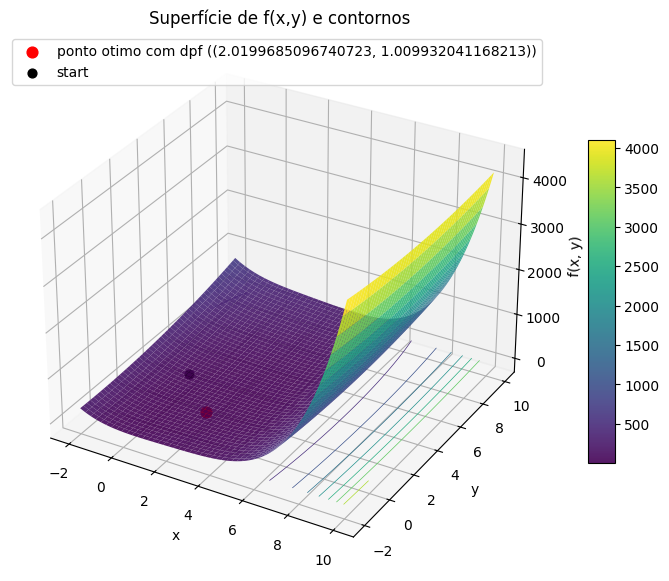

In [ ]:


x = np.linspace(-2.0, 10.0, 200)
y = np.linspace(-2.0, 10.0, 200)
X, Y = np.meshgrid(x, y)

# avalia a função em numpy (mesma expressão usada em `funcao`)
Z = (X - 2.0)**4 + (X - 2.0 * Y)**2

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')


surf = ax.plot_surface(X, Y, Z, cmap='viridis', linewidth=0, antialiased=True, alpha=0.9)
ax.contour(X, Y, Z, zdir='z', offset=Z.min(), cmap='viridis', linewidths=0.5)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)')
fig.colorbar(surf, shrink=0.6, aspect=12)


yini = torch.tensor([0.0, 3.0], dtype=torch.float32, requires_grad=True)
try:
    res = dfp(yini, 10)
    xr = res.detach().cpu().numpy()
    zr = funcao(res).item()
    ax.scatter([xr[0]], [xr[1]], [zr], color='r', s=60, label=f'ponto otimo com dpf ({float(xr[0]), float(xr[1])})')
    ax.scatter([yini[0].item()], [yini[1].item()], [funcao(yini).item()], color='k', s=40, label='start')
    ax.legend()
except Exception as e:
    print('Aviso: não foi possível executar dfp aqui -', e)

plt.title('Superfície de f(x,y) e contornos')
plt.show()


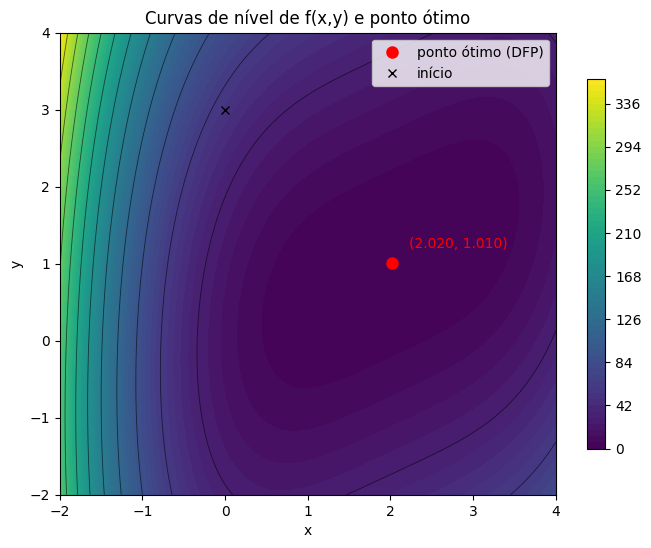

In [ ]:
x = np.linspace(-2.0, 4.0, 400)
y = np.linspace(-2.0, 4.0, 400)
X, Y = np.meshgrid(x, y)
Z = (X - 2.0)**4 + (X - 2.0 * Y)**2

fig, ax = plt.subplots(figsize=(8, 6))
cf = ax.contourf(X, Y, Z, levels=60, cmap='viridis')
# linhas de contorno sobrepostas
cs = ax.contour(X, Y, Z, levels=12, colors='k', linewidths=0.6, alpha=0.6)
fig.colorbar(cf, ax=ax, shrink=0.8)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Curvas de nível de f(x,y) e ponto ótimo')

# ponto inicial e ponto ótimo (tenta rodar dfp; se falhar apenas mostra contornos)
yini = torch.tensor([0.0, 3.0], dtype=torch.float32, requires_grad=True)
try:
    res = dfp(yini, 10)
    xr = res.detach().cpu().numpy()
    ax.plot(xr[0], xr[1], 'ro', markersize=8, label='ponto ótimo (DFP)')
    ax.plot(yini[0].item(), yini[1].item(), 'kx', markersize=6, label='início')
    # opcional: anotar valores
    ax.annotate(f"({xr[0]:.3f}, {xr[1]:.3f})", xy=(xr[0], xr[1]), xytext=(xr[0]+0.2, xr[1]+0.2), color='r')
    ax.legend()
except Exception as e:
    print('Aviso: não foi possível executar dfp aqui -', e)

plt.show()
